In [63]:
# ===== Reduced Order Modeling with NGSolve + pyMOR (POD-Galerkin) =====
import numpy as np
from ngsolve import *
from netgen.geom2d import unit_square

from pymor.algorithms.pod import pod
from pymor.vectorarrays.numpy import NumpyVectorSpace
import matplotlib.pyplot as plt


In [64]:
# ==========================================================
# 1) High-fidelity model (FOM) with parametric 2x2 κ-matrix
# ==========================================================
mesh = Mesh(unit_square.GenerateMesh(maxh=0.05))
V = H1(mesh, order=3, dirichlet="left|right|bottom|top")
u, v = V.TnT()

# --- Parameter-independent right-hand side f ---
f = LinearForm(V)
f += 32 * (y * (1 - y) + x * (1 - x)) * v * dx
f.Assemble()
f_vec = np.array(f.vec)

# --- Reference bilinear forms for each κ entry ---
# κ = [[μ11, μ12],
#      [μ21, μ22]]
a11 = BilinearForm(V, symmetric=True)
a11 += grad(u)[0] * grad(v)[0] * dx
a11.Assemble()

a12 = BilinearForm(V, symmetric=True)
a12 += grad(u)[1] * grad(v)[0] * dx
a12.Assemble()

a21 = BilinearForm(V, symmetric=True)
a21 += grad(u)[0] * grad(v)[1] * dx
a21.Assemble()

a22 = BilinearForm(V, symmetric=True)
a22 += grad(u)[1] * grad(v)[1] * dx
a22.Assemble()

# Full-order solve for given κ
def solve_full(kappa: np.ndarray) -> np.ndarray:
    """kappa: 2x2 array-like of floats."""
    a_mu = BilinearForm(V, symmetric=True)
    a_mu += kappa[0, 0] * grad(u)[0] * grad(v)[0] * dx
    a_mu += kappa[0, 1] * grad(u)[1] * grad(v)[0] * dx
    a_mu += kappa[1, 0] * grad(u)[0] * grad(v)[1] * dx
    a_mu += kappa[1, 1] * grad(u)[1] * grad(v)[1] * dx
    a_mu.Assemble()

    gfu = GridFunction(V)
    gfu.vec.data = a_mu.mat.Inverse(V.FreeDofs()) * f.vec
    return np.array(gfu.vec)  # shape (ndofs,)

# Apply component stiffness to coeff vector
def apply_Acomp(coeffs: np.ndarray, aform: BilinearForm) -> np.ndarray:
    gfu_in = GridFunction(V)
    gfu_in.vec[:] = coeffs
    vec_out = gfu_in.vec.CreateVector()
    vec_out.data = aform.mat * gfu_in.vec
    return np.array(vec_out)


In [112]:
# ==========================================================
# 2) Snapshot generation for multiple κ samples
# ==========================================================
# sample each μ_ij in some range, independently
ntrain = 1000

# --- κ sampler: symmetric positive-definite, bounded anisotropy ---
def sample_anisotropic_spd(k_min=0.01, k_max=20, max_anisotropy=20.0):
    # sample first eigenvalue
    lam1 = np.random.uniform(k_min, k_max)
    # sample anisotropy ratio within bounds
    r = np.random.uniform(1.0, max_anisotropy)
    # second eigenvalue from ratio, clipped to bounds
    lam2 = np.clip(lam1 * r if np.random.rand() < 0.5 else lam1 / r, k_min, k_max)
    # random rotation
    theta = np.random.uniform(0, 2*np.pi)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    # SPD tensor
    return R @ np.diag([lam1, lam2]) @ R.T

snapshots = []
for i in range(ntrain):
    kappa = sample_anisotropic_spd(k_min=0.01, k_max=20.0, max_anisotropy=20.0)
    snapshots.append(solve_full(kappa))

X = np.column_stack(snapshots)           # (ndofs, nsnap)
ndofs, nsnap = X.shape
print(f"ndofs={ndofs}, nsnapshots={nsnap}")


ndofs=4351, nsnapshots=1000


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

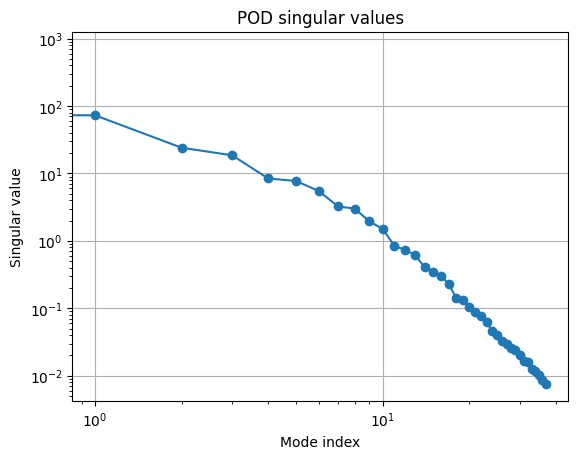

Requested modes=50, obtained modes r=38


In [113]:
# ==========================================================
# 3) POD basis construction
# ==========================================================

max_modes = 50

space = NumpyVectorSpace(ndofs)
snapshots_va = space.from_numpy(X.T)     # shape (nsnap, ndofs)

req_modes = min(max_modes, len(snapshots_va))
RB_va, svals= pod(snapshots_va, modes=req_modes,rtol=1e-5)

plt.loglog(svals, 'o-')
plt.title('POD singular values')
plt.xlabel('Mode index')
plt.ylabel('Singular value')
plt.grid()
plt.show()

Vrb = RB_va.to_numpy().T                # columns: POD basis vecs
r = Vrb.shape[1]
print(f"Requested modes={req_modes}, obtained modes r={r}")

# ==========================================================
# 4) Reduced operators (offline)
# ==========================================================
# Precompute reduced matrices for each κ entry
A11r = Vrb.T @ np.column_stack([apply_Acomp(Vrb[:, j], a11) for j in range(r)])
A12r = Vrb.T @ np.column_stack([apply_Acomp(Vrb[:, j], a12) for j in range(r)])
A21r = Vrb.T @ np.column_stack([apply_Acomp(Vrb[:, j], a21) for j in range(r)])
A22r = Vrb.T @ np.column_stack([apply_Acomp(Vrb[:, j], a22) for j in range(r)])

# Reduced RHS
fr = Vrb.T @ f_vec


In [114]:
# ==========================================================
# 5) Online reduced solve
# ==========================================================
from scipy.linalg import cho_factor, cho_solve
def solve_reduced(kappa: np.ndarray) -> np.ndarray:
    """Solve ROM for 2x2 constant κ tensor.
    
    First tries Cholesky (fast path for SPD systems).
    Falls back to np.linalg.solve if Cholesky fails.
    """
    # Assemble reduced matrix Ar(κ)
    Ar = (
        kappa[0, 0] * A11r
        + kappa[0, 1] * A12r
        + kappa[1, 0] * A21r
        + kappa[1, 1] * A22r
    )
    try:
        # Try Cholesky factorisation and solve
        c, lower = cho_factor(Ar, check_finite=False)
        y = cho_solve((c, lower), fr, check_finite=False)    
    except Exception as e:
        # Warn and fall back
        print(f"Warning: Cholesky solve failed ({e}), using np.linalg.solve instead.")
        y = np.linalg.solve(Ar, fr)

    # Lift back to full‑order space
    return Vrb @ y

kappa_test = np.array([[5.0, 2.0],
                       [1.0, 4.0]])

u_rom = solve_reduced(kappa_test)
u_fom = solve_full(kappa_test)
rel_err = np.linalg.norm(u_fom - u_rom) / np.linalg.norm(u_fom)
print(f"Relative error for kappa={kappa_test.tolist()}: {rel_err:.3e}")


from ngsolve.webgui import Draw
gfu_fom = GridFunction(V); gfu_fom.vec[:] = u_fom
gfu_rom = GridFunction(V); gfu_rom.vec[:] = u_rom
Draw(gfu_rom, mesh, "ROM")
Draw(gfu_fom, mesh, "FOM")


Relative error for kappa=[[5.0, 2.0], [1.0, 4.0]]: 8.076e-05


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [ ]:
import time

# number of tests
n_tests = 100

# store (kappa, u_fom) for later ROM and error calculation
fom_data = []

# --- FOM timing ---
start = time.time()
for _ in range(n_tests):
    kappa_rand = sample_anisotropic_spd(k_min=0.1, k_max=20.0, max_anisotropy=20.0)
    u_fom = solve_full(kappa_rand)
    fom_data.append((kappa_rand, u_fom))
end = time.time()
print(f"Time for {n_tests} FOM solves: {end - start:.3e} seconds")

# --- ROM timing ---
rom_solutions = []
start = time.time()
for kappa_rand, _ in fom_data:
    u_rom = solve_reduced(kappa_rand)
    rom_solutions.append(u_rom)
end = time.time()
print(f"Time for {n_tests} ROM solves: {end - start:.3e} seconds")

# --- L2 relative errors (outside timing) ---
l2_errors = [
    np.linalg.norm(u_fom - u_rom) / np.linalg.norm(u_fom)
    for (_, u_fom), u_rom in zip(fom_data, rom_solutions)
]

print(f"Mean relative L2 error over {n_tests} tests: {np.mean(l2_errors):.3e}")
print(f"Max  relative L2 error over {n_tests} tests: {np.max(l2_errors):.3e}")


Time for 100 FOM solves: 1.320e+00 seconds
Time for 100 ROM solves: 7.002e-03 seconds
Mean relative L2 error over 100 tests: 1.291e-04
Max  relative L2 error over 100 tests: 3.306e-04
